# 🧪 Tox21 Dataset Exploration
This notebook downloads the Tox21 dataset and explores its structure using DeepChem and RDKit.

In [1]:
import deepchem as dc
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Load Tox21 dataset from DeepChem
tox21_tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP',reload=True)
train_dataset, valid_dataset, test_dataset = datasets

print("Number of training samples:", len(train_dataset))
print("Feature shape:", train_dataset.X.shape)
print("Labels shape:", train_dataset.y.shape)


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGenerator
[09:42:14] DEPRECATION WARNING: please use MorganGe

Number of training samples: 6258
Feature shape: (6258, 1024)
Labels shape: (6258, 12)


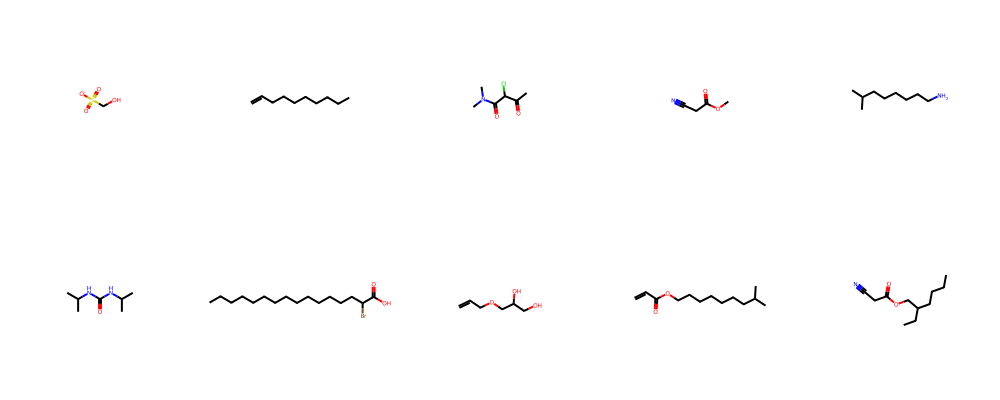

In [10]:
# Convert a few molecules from SMILES and visualize
smiles = train_dataset.ids[405:415]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))


In [11]:
# Show the label matrix for the first few samples
df = pd.DataFrame(train_dataset.y[405:415], columns=tox21_tasks)
df


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


📌 **Next steps**: Featurize with custom fingerprints, try a simple Random Forest model, and evaluate using ROC-AUC.

NR-AR: ROC-AUC = 0.672
NR-AR-LBD: ROC-AUC = 0.805
NR-AhR: ROC-AUC = 0.761
NR-Aromatase: ROC-AUC = 0.653
NR-ER: ROC-AUC = 0.572
NR-ER-LBD: ROC-AUC = 0.626
NR-PPAR-gamma: ROC-AUC = 0.686
SR-ARE: ROC-AUC = 0.609
SR-ATAD5: ROC-AUC = 0.652
SR-HSE: ROC-AUC = 0.636
SR-MMP: ROC-AUC = 0.737
SR-p53: ROC-AUC = 0.697


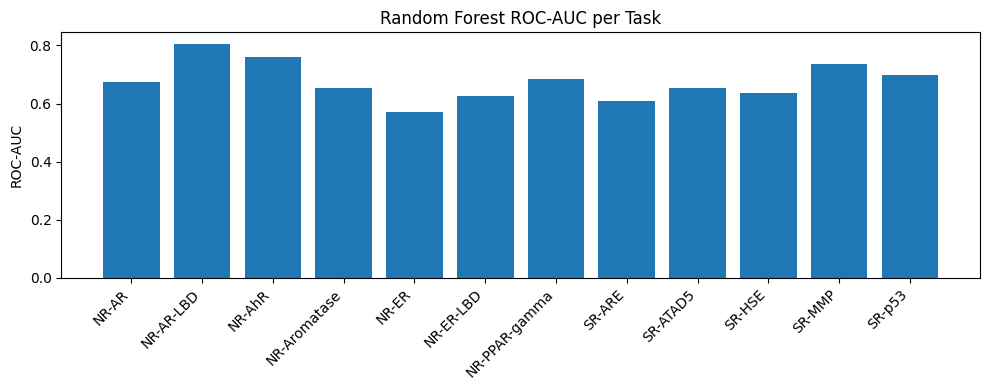

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
X_train, y_train = train_dataset.X, train_dataset.y
X_valid, y_valid = valid_dataset.X, valid_dataset.y
X_test, y_test = test_dataset.X, test_dataset.y

# Train a Random Forest model for each task
rf_models = []
auc_scores = []

for i, task in enumerate(tox21_tasks):
    # Mask out missing labels (NaNs)
    mask = ~np.isnan(y_train[:, i])
    if np.sum(mask) == 0:
        continue
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train[mask], y_train[mask, i])
    rf_models.append(model)

    # Evaluate on test set
    test_mask = ~np.isnan(y_test[:, i])
    if np.sum(test_mask) == 0:
        auc_scores.append(np.nan)
        continue
    y_prob = model.predict_proba(X_test[test_mask])[:, 1]
    auc = roc_auc_score(y_test[test_mask, i], y_prob)
    auc_scores.append(auc)
    print(f"{task}: ROC-AUC = {auc:.3f}")

# Plot ROC-AUC scores
plt.figure(figsize=(10, 4))
plt.bar(tox21_tasks, auc_scores)
plt.ylabel("ROC-AUC")
plt.xticks(rotation=45, ha='right')
plt.title("Random Forest ROC-AUC per Task")
plt.tight_layout()
plt.show()

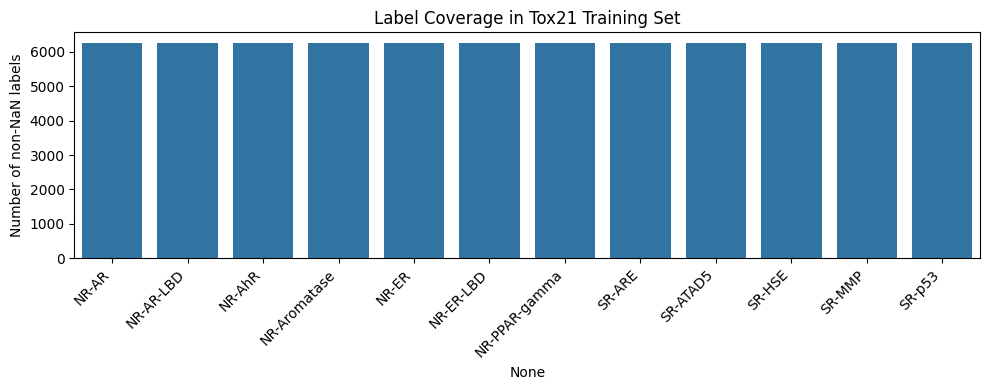

In [14]:
import seaborn as sns
import pandas as pd

label_df = pd.DataFrame(train_dataset.y, columns=tox21_tasks)
plt.figure(figsize=(10, 4))
sns.barplot(x=label_df.columns, y=label_df.notna().sum())
plt.ylabel("Number of non-NaN labels")
plt.xticks(rotation=45, ha='right')
plt.title("Label Coverage in Tox21 Training Set")
plt.tight_layout()
plt.show()